## CONNEXION à la Base postgres et lecture de 3 jours de données

In [1]:
import pandas as pd
import matplotlib
import psycopg2

In [2]:
host="localhost"
port=5432
dbname="hmvl"
username="dirmed"
#pwd="votremotdepasse"

In [77]:
# mise à jour 29/04 : suppression des fichiers en doublon avant l'import en base,
# import 25,26,27 avril
# mise à jour 14/5 : import via csv plus rapide, la table log_imports n'est plus alimentée
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from hmvl;"
hmvl = pd.read_sql_query(sql, conn)
conn = None

In [78]:
nbmes=hmvl.assign(jour=pd.to_datetime(hmvl['hdt']).dt.to_period('D'))
nbmes=nbmes.groupby(['jour','station']).count().sort_values(by='hdt')
nbmes=nbmes.rename(columns={'hdt':'nb_mes','vitesse':'nbmesvit','longueur':'nbmeslong'})
nbmes=nbmes[['nb_mes','nbmesvit','nbmeslong']]


/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [86]:
status2=hmvl[hmvl["status"]=="2"][["hdt","station"]]
status2=status2.assign(jour=pd.to_datetime(status2['hdt']).dt.to_period('D'))
status2=status2.groupby(['jour','station']).count().sort_values(by='hdt')
status2=status2.rename(columns={'hdt':'nb_status2'})

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [91]:
qualite=pd.merge(nbmes,status2,on=['jour','station'],how='outer')

In [90]:
hmvl=hmvl[hmvl["status"]=="0"][["id","hdt","station","voie","vitesse","longueur","statuttr"]]
sansvoie=hmvl[hmvl["voie"].isna()][["hdt","station","statuttr"]]
sansvoie=sansvoie.assign(jour=pd.to_datetime(sansvoie['hdt']).dt.to_period('D'))
sansvoie=sansvoie.groupby(['station','jour']).count().sort_values(by='hdt')

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [96]:
sansvoie=sansvoie.rename(columns={'hdt':'nb_sansvoie'})['nb_sansvoie']

In [98]:
qualite=pd.merge(qualite,sansvoie,on=['jour','station'],how='outer')

In [102]:
qualite.fillna(0.0)

nb_mes  nbmesvit  nbmeslong  nb_status2    hdt  statuttr  \
jour       station                                                             
2020-04-24 MPG         134        65         65         0.0    0.0       0.0   
           MPB         135        27         56         0.0    0.0       0.0   
           MPF         139        86         86         0.0    0.0       0.0   
           MBO         173       142        142         0.0    0.0       0.0   
           MPA         262       248        250         0.0    0.0       0.0   
...                    ...       ...        ...         ...    ...       ...   
2020-04-27 M8F       35722     31691      31691      3913.0  118.0     118.0   
           M3p       37078     36281      36301         1.0  742.0     742.0   
           M3r       37158     36389      36384         1.0  737.0     737.0   
           M3j       50248     49668      49712         1.0  488.0     488.0   
           M3k       52199     51603      51661         0.0  477.0     477.0   

                    nb_sansvoie  
jour       station               
2020-04-24 MPG              0.0  
           MPB              0.0  
           MPF              0.0  
           MBO              0.0  
           MPA              0.0  
...                         ...  
2020-04-27 M8F            118.0  
           M3p            742.0  
           M3r            737.0  
           M3j            488.0  
           M3k            477.0  

[445 rows x 7 columns]

In [8]:
# attention en base les horodates sont sur la timezone de Paris mais elles sont lues par défaut en UTC
h=hmvl["hdt"]
min(h) , max(h), max(h)-min(h)

(Timestamp('2020-04-24 22:00:00+0000', tz='UTC'),
 Timestamp('2020-04-27 21:59:42.680000+0000', tz='UTC'),
 Timedelta('2 days 23:59:42.680000'))

In [17]:
h2=h.apply(lambda x: x.tz_convert('Europe/Paris'))

In [19]:
min(h2) , max(h2), max(h2)-min(h2)
# il faut passer en heure de Paris pour avoir des dates correctes

(Timestamp('2020-04-25 00:00:00+0200', tz='Europe/Paris'),
 Timestamp('2020-04-27 23:59:42.680000+0200', tz='Europe/Paris'),
 Timedelta('2 days 23:59:42.680000'))

## rapide examen des données

In [14]:
hmvl.dtypes

id                        int64
hdt         datetime64[ns, UTC]
station                  object
voie                     object
vitesse                 float64
longueur                float64
statuttr                 object
dtype: object

In [17]:
hmvl.describe()

,id,vitesse,longueur
count,4.337407e+06,4.166667e+06,4.194868e+06
mean,3.327450e+06,9.578979e+01,4.302708e+00
std,1.824326e+06,1.848435e+01,2.057119e+00
min,9.000000e+00,0.000000e+00,0.000000e+00
25%,1.604698e+06,8.400000e+01,3.600000e+00
50%,3.645032e+06,9.300000e+01,4.000000e+00
75%,4.931450e+06,1.060000e+02,4.500000e+00
max,6.197846e+06,9.990000e+02,9.990000e+01


In [6]:
print(hmvl["statuttr"].value_counts())
# a priori on garde les statuts B et @
# pour H que fait-on ? en principe c'est une erreur interne mais les valeurs ont l'air correctes
# de même pour J... et les autres valeurs ne sont pas documentées
# par exemple avec le statuttr J il n'y a aucune ligne avec le status 2
print(hmvl[(hmvl["status"]=="2") & (hmvl["statuttr"]=="J")])
# -> a priori le Status TR n'apporte pas d'info permettant d'éliminer des mesures
hmvl[hmvl["statuttr"]=="H"][:20]


B    2995816
@    1940697
H     431897
J     248979
4        483
1         65
b         62
I         21
          11
3          3
Name: statuttr, dtype: int64
Empty DataFrame
Columns: [id, horodate_id, hdt, station, status, voie, vitesse, longueur, statuttr]
Index: []


,id,horodate_id,hdt,station,status,voie,vitesse,longueur,statuttr
18,19,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:18+00:00,M1c,0,None,NaN,NaN,H
25,26,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:29.570000+00:00,M1b,0,0,115.0,5.4,H
26,27,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:29.800000+00:00,M1b,0,1,111.0,4.3,H
99,100,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:31.690000+00:00,M1h,0,0,113.0,3.2,H
100,101,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:34.510000+00:00,M1h,0,0,84.0,3.1,H
115,116,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:31.960000+00:00,M1B,0,1,84.0,3.9,H
154,155,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:18+00:00,M3x,0,None,NaN,NaN,H
165,166,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:31.690000+00:00,M7j,0,0,85.0,11.5,H
166,167,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:32.600000+00:00,M7j,0,1,101.0,4.4,H
167,168,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:33.240000+00:00,M7j,0,0,85.0,5.7,H


## On peut éliminer les données de status 2

In [28]:
print(hmvl["status"].value_counts())
# il reste 20% de données avec le status 2
# pour toutes les données avec le status 2 : voie est None, et longueur et vitesse sont Nan
hmvl[hmvl["status"]=="2"]["voie"].isna().sum()

0    5449199
2     609726
Name: status, dtype: int64


609726

#### on peut garder un dataframe status2 pour avoir les stats par station et par jour

In [4]:
#pas besoin de garder statuttr: pour status=2: statuttr=NULL
# on pourrait stocker en base dans une table le nb de status=2 par jour par station par jour
status2=hmvl[hmvl["status"]=="2"][["hdt","station"]]

In [5]:
status2=status2.assign(jour=pd.to_datetime(status2['hdt']).dt.to_period('D'))

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [6]:
status2=status2.groupby(['jour','station']).count().sort_values(by='hdt')

In [7]:
#S2.to_csv(index=True)
status2=status2.rename(columns={'hdt':'nb_status2'})

In [8]:
status2.head()

nb_status2
jour       station            
2020-04-26 M4h               1
2020-04-27 M3s               1
           M3r               1
           M3p               1
           M3l               1

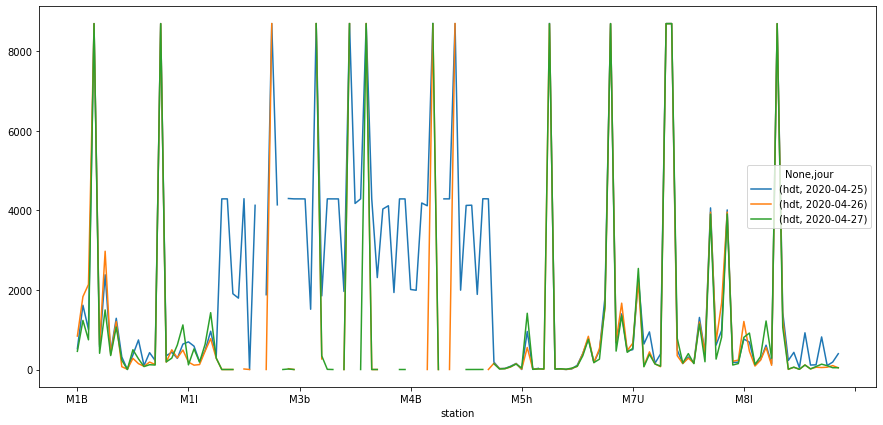

In [28]:
fig, ax = matplotlib.pyplot.subplots(figsize=(15,7))
status2.groupby(['station','jour']).count().sort_values(by='hdt').unstack().plot(ax=ax)

### On travaille maintenant avec les mesures status=0

In [56]:
hmvl=hmvl[hmvl["status"]=="0"][["id","hdt","station","voie","vitesse","longueur","statuttr"]]
# 5,4 M de mesures pour 3 jours

### On peut éliminer les mesures qui voie=NULL

In [97]:
print(hmvl["longueur"].isnull().sum())
print(hmvl["vitesse"].isnull().sum())
print(hmvl["voie"].isnull().sum())
print(hmvl[(hmvl["voie"].isnull()) & (hmvl["vitesse"].isnull()) & (hmvl["longueur"].isnull())].count())
# pour les données de status 0 (Ok) il y a 20% de mesures vides
# quand voie est NULL, vitesse et longueur sont aussi NULL (ce qui est cohérent)
# donc on peut supprimer toutes les mesures pour lesquelles voies est nulles

1254331
1282532
1111792
id          1111792
hdt         1111792
station     1111792
voie              0
vitesse           0
longueur          0
statuttr    1111792
dtype: int64


In [18]:
sansvoie=hmvl[hmvl["voie"].isna()][["hdt","station","statuttr"]]

In [20]:
sansvoie=sansvoie.assign(jour=pd.to_datetime(sansvoie['hdt']).dt.to_period('D'))

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [22]:
sansvoie=sansvoie.groupby(['station','jour']).count().sort_values(by='hdt')
# à voir si les mesures vides sont liées au jour, le 26 en a plus (550k) que le 27 (240k) alors que c'est un dimanche

In [30]:
sansvoie=sansvoie.rename(columns={'hdt':'nb_sansvoie'})['nb_sansvoie']

In [34]:
qualite=pd.merge(status2,sansvoie,on=['jour','station'])


In [58]:
S3.columns

Index(['hdt', 'statuttr'], dtype='object')

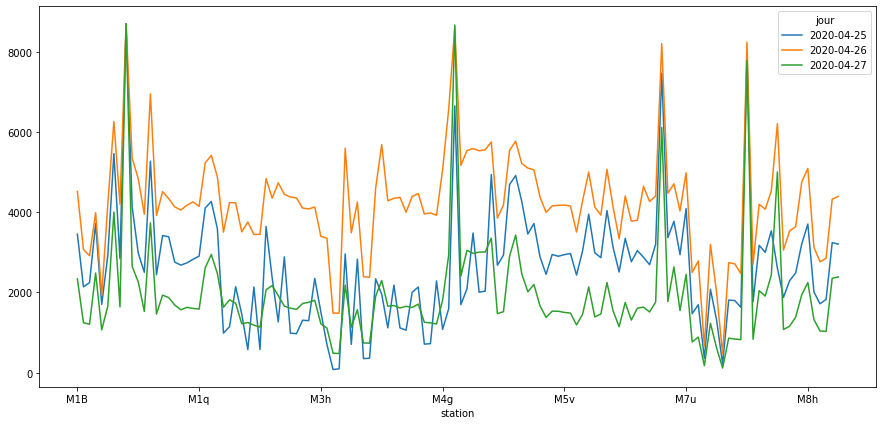

In [33]:
fig, ax = matplotlib.pyplot.subplots(figsize=(15,7))
sansvoie.groupby(['station','jour']).count()['hdt'].sort_values().unstack().plot(ax=ax)
# comme pour les stations en status=2, certaines stations posent plus de problèmes, 
# mais beaucoup de stations ont plus de 1000 mesures vides par jour
# à jour si les stations sont toutes sur le même axe auquel cas ça pourrait être lié aux transmissions

### On travaille maintenant avec les mesures status=0

In [57]:
hmvl=hmvl[hmvl["voie"].notna()][["id","hdt","station","voie","vitesse","longueur","statuttr"]]
# restent 4,3 M de mesures pour 3 jours

In [67]:
len(hmvl)
nbmes=hmvl.assign(jour=pd.to_datetime(hmvl['hdt']).dt.to_period('D'))
nbmes=nbmes.groupby(['jour','station']).count().sort_values(by='hdt')

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [73]:
nbmes=nbmes.rename(columns={'hdt':'nb_mes','vitesse':'nbmesvit','longueur':'nbmeslong'})
nbmes=nbmes[['nb_mes','nbmesvit','nbmeslong']]
nbmes.head()

nb_mes  nbmesvit  nbmeslong
jour       station                             
2020-04-27 M4j          40         0         40
2020-04-25 M4j          66         0         66
2020-04-26 M4j         113         0        113
           M7o         462       460        460
2020-04-25 M7o         936       936        936

In [76]:
qualite.head(34)

nb_status2  nb_sansvoie  nb_mes  nbmesvit  nbmeslong
jour       station                                                      
2020-04-26 M4h               1         6570    2548      2546       2545
2020-04-27 M3s               1         1907   16761     16696      16737
           M3r               1          738   36420     36389      36384
           M3p               1          743   36335     36281      36301
           M3l               1         2186   15305     15273      15273
           M3j               1          489   49759     49668      49712
           M3Z               1         1580   19633     19186      19183
2020-04-26 M3s               1         4599    6091      6066       6084
2020-04-27 M3X               1         1661   19252     19181      19181
2020-04-25 M3L               1         2137   14720     14024      14024
2020-04-27 M3O               1         2067   15263     15226      15226
2020-04-26 M3y               1         4369    6483      6460       6460
2020-04-27 M3D               1         1734   18000     16091      16091
           M3C               1         1817   18190     18112      18112
           M3B               1         1633   22148     21827      21827
2020-04-26 M4d               1         3983    7268      7253       7253
           M4f               1         3924    7587      7576       7580
           M4m               1         5585    4162      4156       4162
           M4o               1         5556    4085      4081       4080
2020-04-27 M3z               1         1656   19016     18961      18961
           M3y               1         1615   19086     19034      19034
           M4k               1         2410   13716     11967      11967
2020-04-26 M3B               1         3504    9049      8777       8777
           M3C               1         4239    6896      6862       6862
           M3D               1         4235    6802      6452       6452
           M3L               1         3446    9806      8137       8139
           M3P               1         4349    6700      1576       6696
2020-04-27 M4f               1         1216   26004     25967      25983
2020-04-26 M3c               1         4081    7225      7216       7216
           M3Z               1         4356    6347      6255       6254
           M3j               1         1488   17444     17411      17424
           M3l               1         5596    4173      4139       4139
           M3r               1         2377   12754     12745      12745
2020-04-27 M4m               1         2975   10957     10935      10954

In [74]:
qualite=pd.merge(qualite,nbmes,on=['jour','station'])

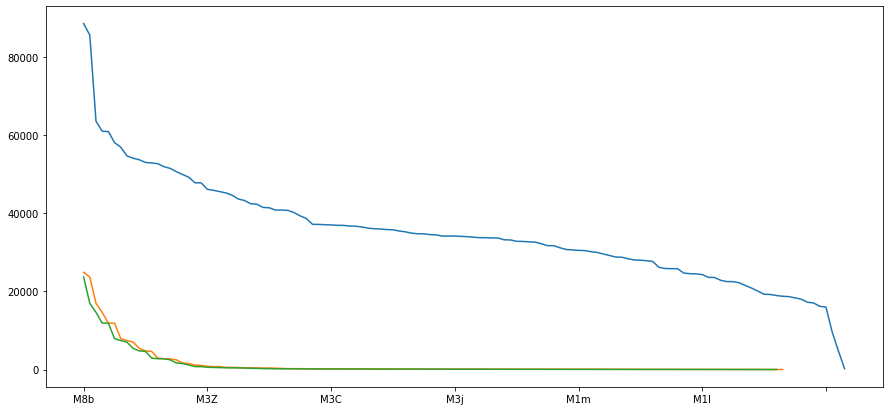

In [44]:
hmvl["station"].value_counts().plot(figsize=(15,7))
hmvl[hmvl["vitesse"].isna()]["station"].value_counts().plot()
hmvl[hmvl["longueur"].isna()]["station"].value_counts().plot()
# Il reste quelaques (une dizaine de stations) avec des vitesses ou longueurs vides
# là aussi on pourrait calculer un indicateur par station et par jour
# et le stocker en base


In [12]:
# essai de moyenne 6'
#moy6m=hmvl.groupby(['station'])['vitesse','longueur'].resample('6Min')
hmvl = hmvl.set_index('hdt')

In [15]:
moy6m=hmvl.groupby(['station'])['vitesse','longueur'].resample('6Min').mean()

<ipython-input-15-1598f5f52ec4>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  moy6m=hmvl.groupby(['station'])['vitesse','longueur'].resample('6Min').mean()


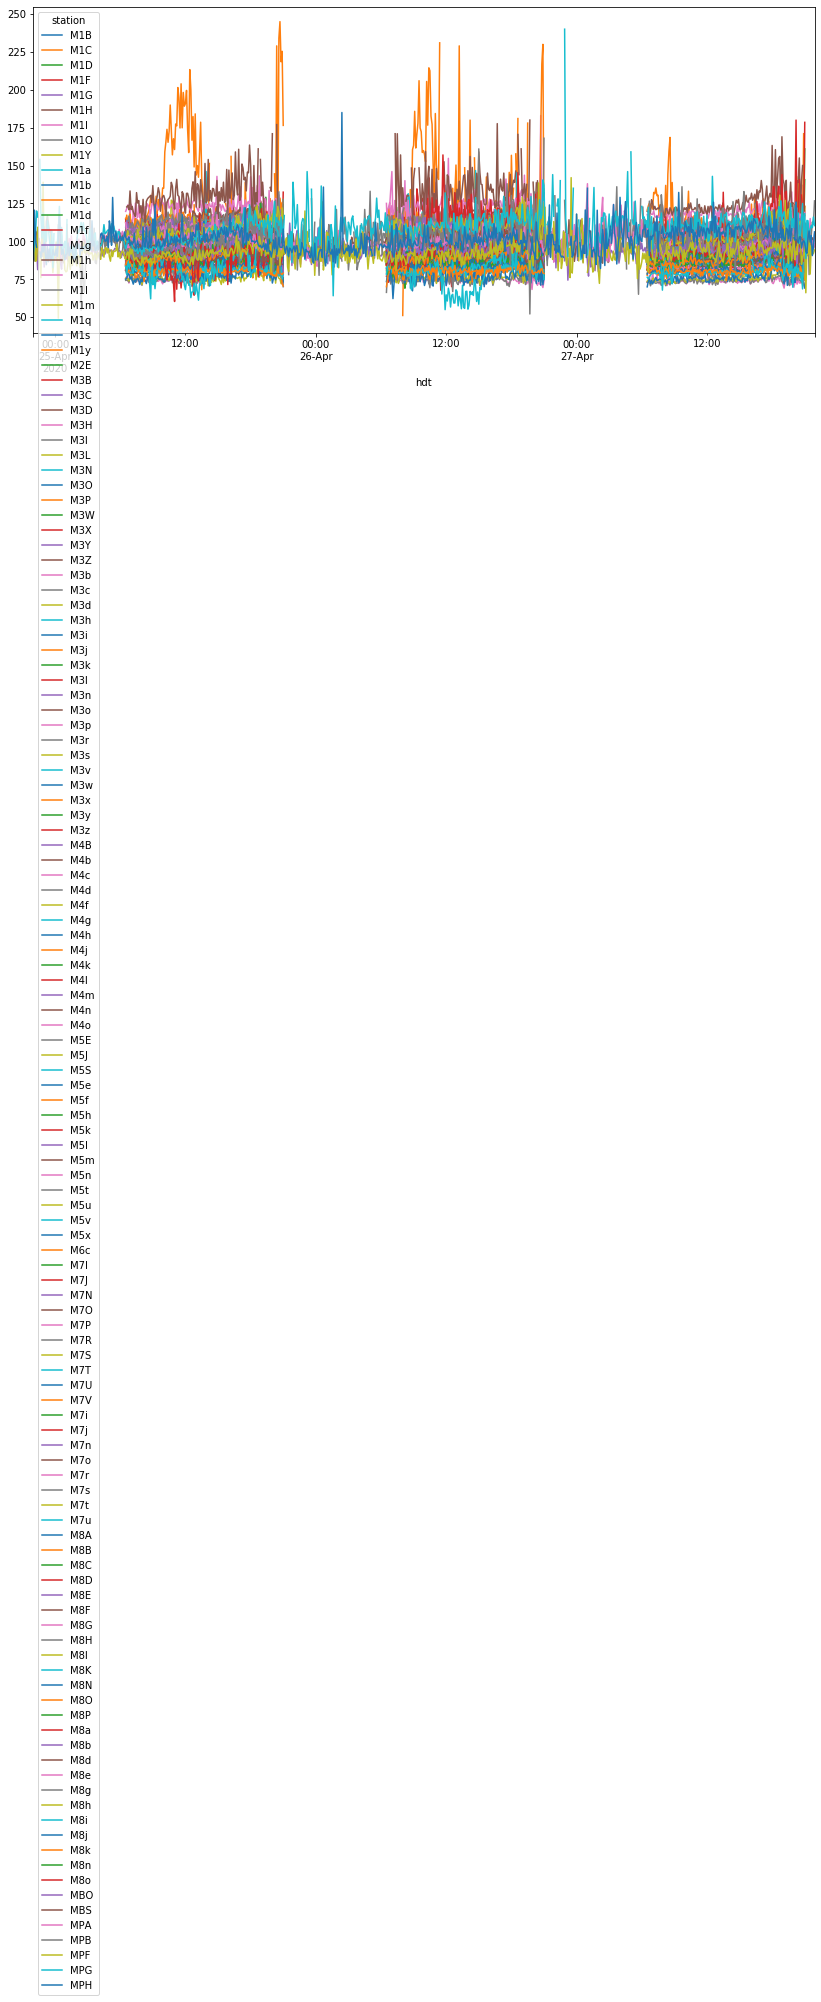

In [22]:
moy6m['vitesse'].unstack().T.plot(figsize=(14,6))

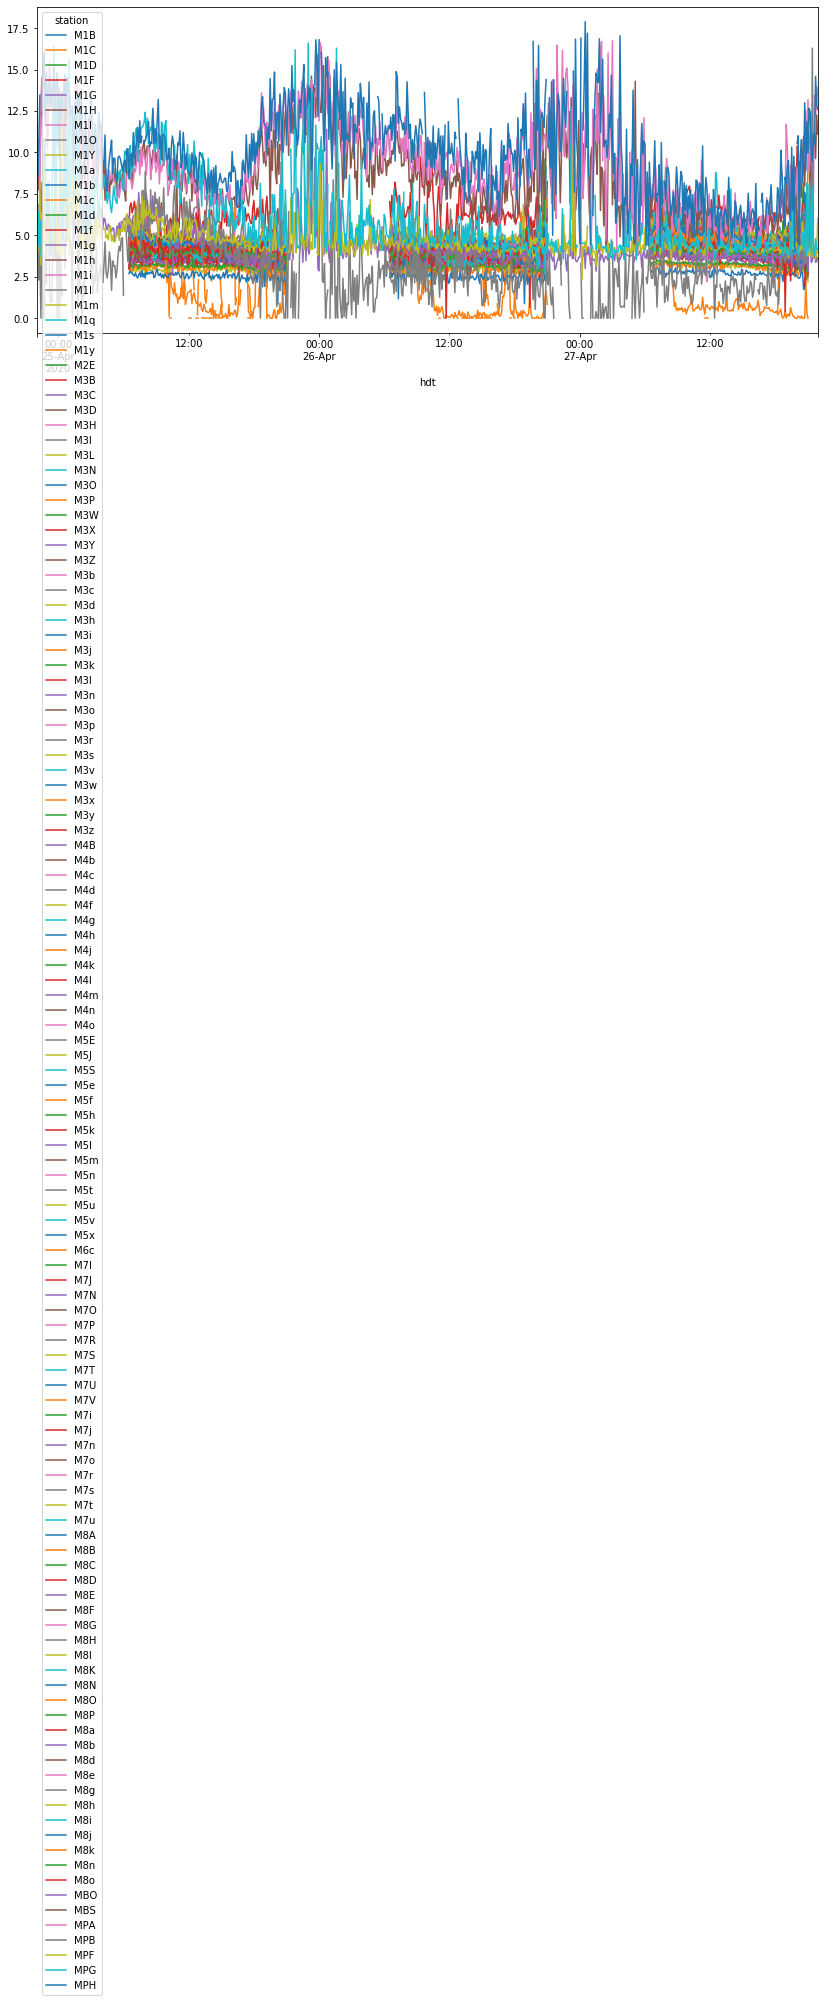

In [45]:
moy6m['longueur'].unstack().T.plot(figsize=(14,6))

In [42]:
moy6m['vitesse'].unstack().T.apply(lambda x:round(x,2)).to_csv(path_or_buf="/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/m6v.csv")
moy6m['longueur'].unstack().T.apply(lambda x:round(x,2)).to_csv(path_or_buf="/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/m6l.csv")


In [49]:
# calcul des débits 6', la fonction size prend en compte les mesures avec des valeurs de V vides
moy6q=hmvl.groupby(['station'])['vitesse'].resample('6Min').size()
moy6q.head()
moy6q.unstack().T.to_csv(path_or_buf="/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/m6q.csv")


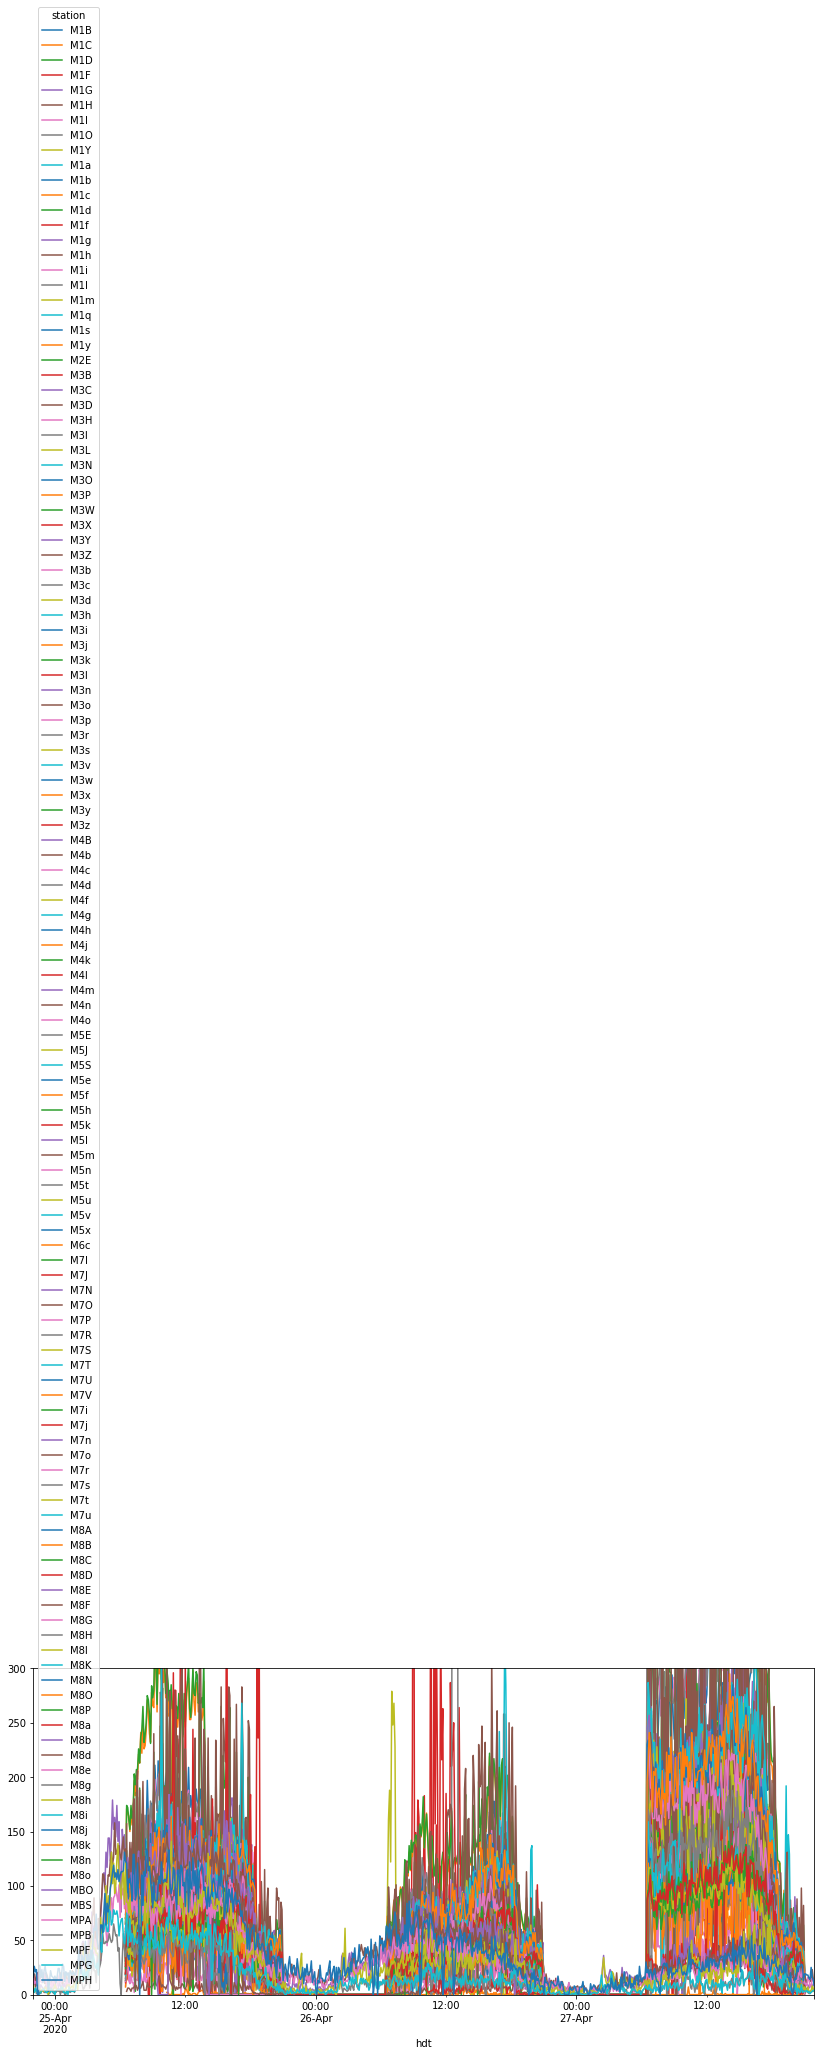

In [48]:
moy6q.unstack().T.plot(figsize=(14,6),ylim=(0,300))
# on n'affiche pas les débits > 300 par 6' qui sont a priori aberrants??

In [51]:
hmvl.index.min() , hmvl.index.max(), hmvl.index.max()-hmvl.index.min()
# les horodates sont OK mais attention on est en UTC donc la journée commence la veille à 22H en heures d'été
#hmvl["hdt"].tz_convert('Europe/Paris')

(Timestamp('2020-04-24 22:00:02.180000+0000', tz='UTC'),
 Timestamp('2020-04-27 21:59:42.680000+0000', tz='UTC'),
 Timedelta('2 days 23:59:40.500000'))

In [53]:
hmvl.index.value_counts()
# il reste des doublons, à investiguer, ça peut expliquer les débits aberrants

2020-04-27 14:32:14.890000+00:00    9
2020-04-27 09:52:53.310000+00:00    8
2020-04-27 13:31:37.690000+00:00    7
2020-04-27 06:36:22.230000+00:00    7
2020-04-25 10:36:34.680000+00:00    7
                                   ..
2020-04-25 14:37:37.260000+00:00    1
2020-04-26 15:39:54.160000+00:00    1
2020-04-27 11:12:19.760000+00:00    1
2020-04-25 08:11:57.650000+00:00    1
2020-04-26 06:33:41.990000+00:00    1
Name: hdt, Length: 3752405, dtype: int64

In [55]:
#listedates=hmvl["horodate_id"].str[:10]
#listedates.value_counts()
#obsolète on a enlevé la colonne texte horodate_id
# les dates labocom sont au format AAAA-MM-JJ, les dates RD sont au format Day Mon DD

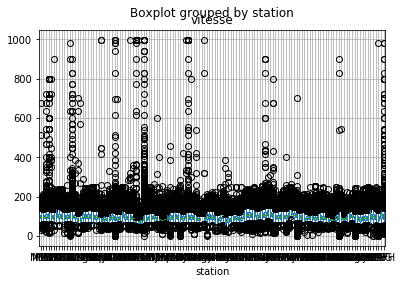

In [56]:
hmvl.boxplot(column=["vitesse"],by="station")
# ça semble raisonnable de prendre 280 (voire 240) comme valeur seuil de vitesse

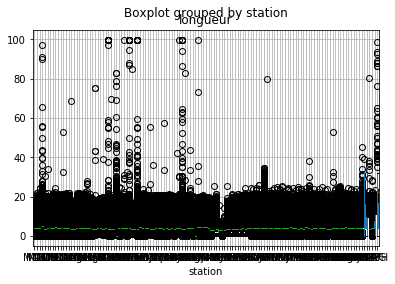

In [57]:
hmvl.boxplot(column=["longueur"],by="station")
# ça semble raisonnable de prendre 25 comme valeur seuil de longueur, 
# mais il y a peut être valeur plus pertinente pour le métier, à cause des Transports Exceptionnels par exemple?
# ou pour voir passer les convois ITER s'ils empruntent le réseau DIRMED?

In [58]:
print(hmvl['voie'].value_counts())
# on a éliminé de hmvl les mesures sans numéro de voie
# 
sum(pd.isna(hmvl['voie']))

0    1767712
1    1516742
2     746664
3     300751
4     142378
5      27411
Name: voie, dtype: int64


0

In [22]:
M8i=hmvl[hmvl["station"]=="M8i"]
M8i.head(5)

,id,horodate_id,hdt,station,status,voie,vitesse,longueur,statuttr
149,150,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:18+00:00,M8i,0,None,NaN,NaN,B
336,337,Sat Apr 25 08:40:24 2020,2020-04-25 06:40:36.300000+00:00,M8i,0,0,81.0,3.6,B
337,338,Sat Apr 25 08:40:24 2020,2020-04-25 06:40:36.540000+00:00,M8i,0,2,NaN,NaN,B
522,523,Sat Apr 25 08:40:30 2020,2020-04-25 06:40:30+00:00,M8i,0,None,NaN,NaN,B
715,716,Sat Apr 25 08:40:36 2020,2020-04-25 06:40:36+00:00,M8i,0,None,NaN,NaN,B


In [23]:
len(M8i["hdt"])
# nb de mesures dans la journée

56638

### RECHERCHE DES DOUBLONS

In [8]:
hmvl.head(5)

,id,hdt,station,voie,vitesse,longueur,statuttr
8,9,2020-04-25 06:40:24.620000+00:00,M3d,0,81.0,4.0,B
11,12,2020-04-25 06:40:29.180000+00:00,M5h,1,75.0,3.0,B
12,13,2020-04-25 06:40:26.260000+00:00,M5l,3,87.0,4.1,B
13,14,2020-04-25 06:40:30.830000+00:00,M3j,0,71.0,4.9,@
14,15,2020-04-25 06:40:31.800000+00:00,M3j,1,90.0,4.0,@


In [61]:
idu=hmvl.groupby("hdt")["id"].unique()
# sur 4,3M mesures, seulement 52092 correspondent à une seule horodate

In [11]:
idu.apply(len).value_counts()
# il reste environ 20% de doublons : à creuser !!
# il y a 20% d'horodates identiques mais 
# cf. cellule ci-dessous soit c'est pour une station différente soit pour une voie différente

NameError: name 'idu' is not defined

In [9]:
id_hv=hmvl.groupby(["hdt","station","voie"])["id"].unique()
id_hv.apply(len).value_counts()
# sur 1,8M mesures, il y désormais très peu de doublons, moins de 1 pour mille
# 

1    4331949
2       2729
Name: id, dtype: int64

In [24]:
doubles=[]
for i in range(len(id_hv)):
    x=id_hv.iloc[i]
    y=id_hv.index[i]
    if len(x)<2: continue
    doubles.append((x,y))

In [29]:
# il y a peu de doublons, difficile de dire à quoi ils sont dus, 
# on note que ils correspondent à des indices proches, mais c'est normal puisque les mesures sont lues dans l'ordre chrono
# donc des mesures de même horodate sont en principe dans des fichiers proches
# la mesure a priori serait de supprimer un des 2 doublons.
# cela peut être fait a posteriori en base en SQL  mais ça risque d'être un peu lourd à effectuer

In [28]:
doubles[1200:1400]

[(array([3696707, 3735577]),
  (Timestamp('2020-04-27 08:38:58+0000', tz='UTC'), 'M4k', '2')),
 (array([3698151, 3785019]),
  (Timestamp('2020-04-27 08:39:48.970000+0000', tz='UTC'), 'M8b', '0')),
 (array([3785903, 3787489]),
  (Timestamp('2020-04-27 08:40:14.360000+0000', tz='UTC'), 'M7V', '0')),
 (array([3688764, 3690438]),
  (Timestamp('2020-04-27 08:41:03.590000+0000', tz='UTC'), 'M3k', '4')),
 (array([3689747, 3691465]),
  (Timestamp('2020-04-27 08:41:17.940000+0000', tz='UTC'), 'M3l', '1')),
 (array([3690289, 3692021]),
  (Timestamp('2020-04-27 08:41:25.790000+0000', tz='UTC'), 'M3x', '1')),
 (array([3690220, 3691933]),
  (Timestamp('2020-04-27 08:41:32.910000+0000', tz='UTC'), 'M4g', '1')),
 (array([3691483, 3781654]),
  (Timestamp('2020-04-27 08:42:11.800000+0000', tz='UTC'), 'M8K', '1')),
 (array([3781646, 3783264]),
  (Timestamp('2020-04-27 08:42:12.250000+0000', tz='UTC'), 'M3i', '1')),
 (array([3782708, 3784335]),
  (Timestamp('2020-04-27 08:42:54.430000+0000', tz='UTC'), '

### tests divers

In [22]:
j='2020-04-26'
import datetime

In [27]:
veille=(datetime.date(*map(int, j.split('-'))) - datetime.timedelta(days=1)).strftime('%Y-%m-%d')


In [26]:
veille

'2020_04_25'